# Predictive Fire Outbreaks

In this script, we attempt to use triple exponential smoothing to establish a pattern in the outbreaks of fires in London and predict the frequency of future incidents. By disecting the patterns, and looking at incidents by region, we can also then predict where is most susceptible looking forward. With information on the repsonse times by region, we can prescribe the candidate locations of new fire stations, or at least increased access routes.

In [2]:
# Import libraries

import time
import os
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d # Linear interpolation method
from scipy.stats import linregress # For linear regression analysis
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose # For seasonal decomposition

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # For 3D plotting
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Plotting autocorrelation and partial autocorrelation
import seaborn as sns

# Format plotting
sns.set_theme(context="notebook", style="darkgrid", palette = "flare")
palette = sns.color_palette("flare", as_cmap=False)
palette_cmap = sns.color_palette("flare", as_cmap=True)

C:\Users\conal\AppData\Local\Temp\ipykernel_18484\96931417.py:26: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  fire_monthly = fire_data.resample('M').size().reset_index(name='FireCount')


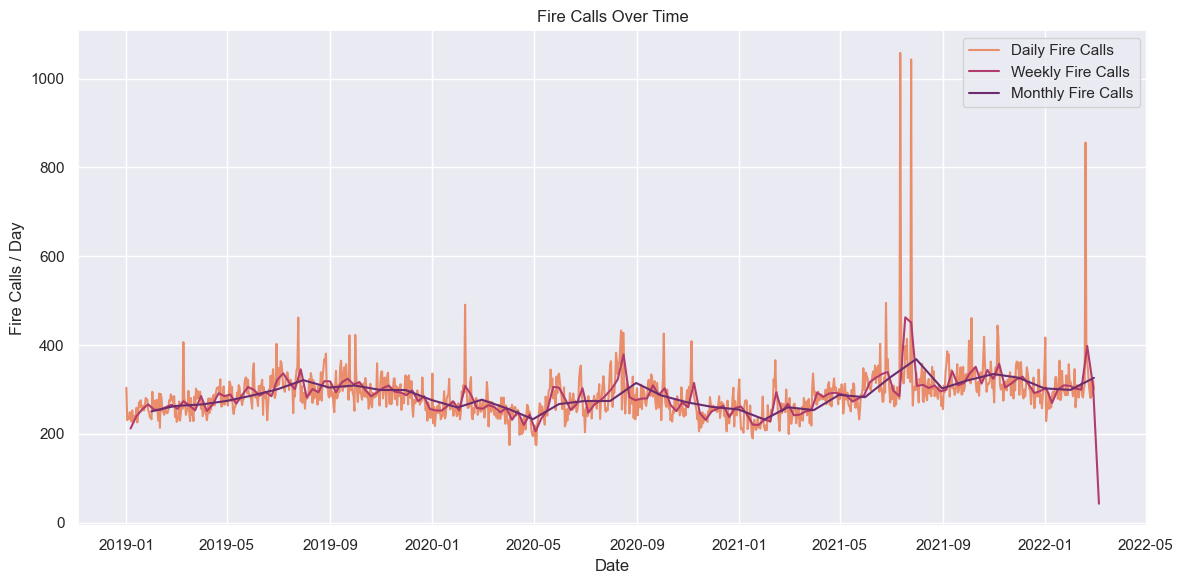

In [3]:
# Import and restructure data

data_path = os.path.join(os.getcwd(), 'Data Sets')
plot_path = os.path.join(os.getcwd(), 'Plots', 'Predictive_analysis')

fire_data = pd.read_csv(os.path.join(data_path, 'fire_data.csv'))
# Covert DateOfCall and TimeOfCall data type to datetime in a single column
fire_data['DateTime'] = pd.to_datetime(fire_data['DateOfCall'] + ' ' + fire_data['TimeOfCall'])
fire_data.set_index('DateTime', inplace=True)
# Drop the original DateOfCall and TimeOfCall columns
fire_data.drop(columns=['DateOfCall', 'TimeOfCall', 'CalYear', 'HourOfCall'], inplace=True)

# Count the number of fire calls per day
fire_daily = fire_data.resample('D').size().reset_index(name='FireCount')
fire_daily['DateTime'] = pd.to_datetime(fire_daily['DateTime'])
fire_daily.set_index('DateTime', inplace=True)

# Count the number of fire calls per week and normalize by the number of days in each week
fire_weekly = fire_data.resample('W').size().reset_index(name='FireCount')
fire_weekly['DateTime'] = pd.to_datetime(fire_weekly['DateTime'])
fire_weekly['DaysInWeek'] = (fire_weekly['DateTime'] - fire_weekly['DateTime'].shift(1)).dt.days.fillna(7)  # Calculate actual days in each week
fire_weekly['NormalisedFireCount'] = fire_weekly['FireCount'] / fire_weekly['DaysInWeek']
fire_weekly.set_index('DateTime', inplace=True)

# Count the number of fire calls per month and normalize by the number of days in each month
fire_monthly = fire_data.resample('M').size().reset_index(name='FireCount')
fire_monthly['DateTime'] = pd.to_datetime(fire_monthly['DateTime'])
fire_monthly['DaysInMonth'] = fire_monthly['DateTime'].dt.daysinmonth
fire_monthly['NormalisedFireCount'] = fire_monthly['FireCount'] / fire_monthly['DaysInMonth']
fire_monthly.set_index('DateTime', inplace=True)

# Plot the number of fire calls per day, week, and month on a single graph
plt.figure(figsize=(12, 6))
plt.plot(fire_daily.index, fire_daily['FireCount'], label='Daily Fire Calls', color=palette[0])
plt.plot(fire_weekly.index, fire_weekly['NormalisedFireCount'], label='Weekly Fire Calls', color=palette[3])
plt.plot(fire_monthly.index, fire_monthly['NormalisedFireCount'], label='Monthly Fire Calls', color=palette[-1])
plt.title('Fire Calls Over Time')
plt.xlabel('Date')
plt.ylabel('Fire Calls / Day')
plt.legend()
plt.tight_layout()
plt.show()


The graph above shows a drastic fall in the number of fire calls in the final week/month, likely because this week.month is incomplete. As a result, the final value will be omitted before dividing the data set into training test and validation sets. Using weekly data will enable optimisation for triple exponential smoothing by lowering the value for m.

C:\Users\conal\AppData\Local\Temp\ipykernel_18484\1672432056.py:61: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(0.02, 0.95, f'Optimised Model:\n Level: {model2.level[-1]:.2f}\nAlpha: {model2.params["smoothing_level"]:.2f}\nBeta: {model2.params["smoothing_trend"]:.2f}\nGamma: {model2.params["smoothing_seasonal"]:.2f}\nm: {m}', transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))


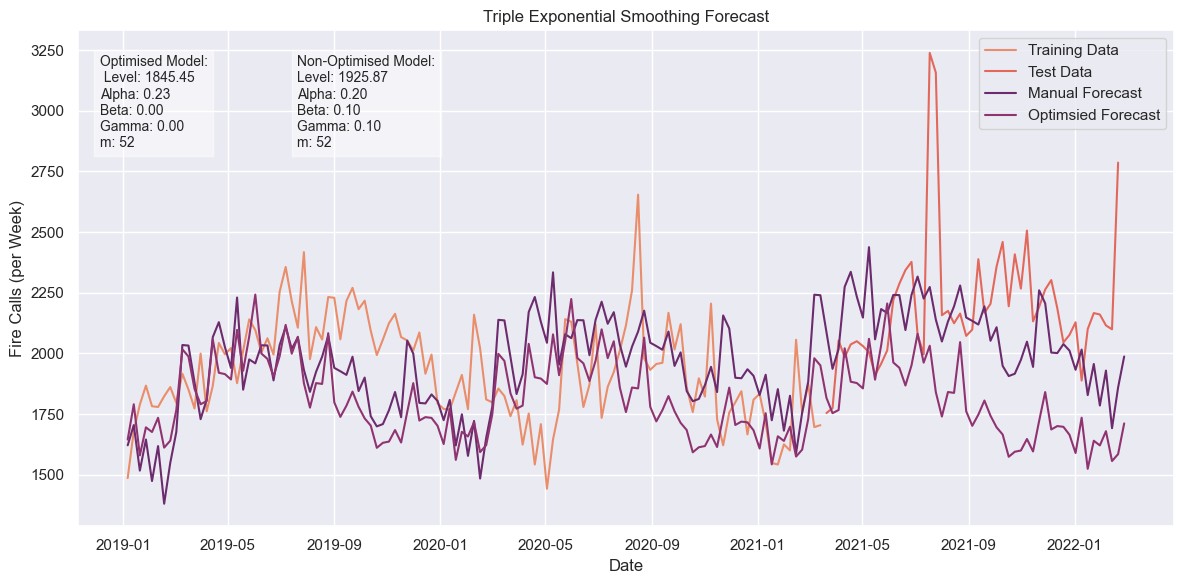

In [4]:
# Triple Exponential Smoothing

# Omit the final week to avoid incomplete data
fire_weekly = fire_weekly[:-1]  # Remove the last week to avoid incomplete data
# Ensure the frequency is explicitly set to weekly
fire_weekly = fire_weekly.asfreq('W-SUN')

# Split the data into training, test, and validation sets
train_size = int(len(fire_weekly) * 0.7)
test_size = int(len(fire_weekly) * 0.3)
# validation_size = len(fire_weekly) - train_size - test_size

train_data = fire_weekly.iloc[:train_size]
test_data = fire_weekly.iloc[train_size:train_size + test_size]
# validation_data = fire_weekly.iloc[train_size + test_size:]

# Assign reasonable level, alpha, beta, gamma and m values

# Level is the mean value of the training data
level = train_data['FireCount'].mean()
# Alpha is set to 0.2, a common starting point
alpha = 0.2
# Beta is set to 0.1, a common starting point
beta = 0.1
# Gamma is set to 0.1, a common starting point
gamma = 0.1
# m is the number of periods in a season, set to 52 for weekly data
m = 52

# Fit the model
model1 = ExponentialSmoothing(train_data['FireCount'],
                            trend='add',
                            seasonal='add',
                            seasonal_periods=m).fit(
    smoothing_level=alpha,
    smoothing_trend=beta,
    smoothing_seasonal=gamma,
    optimized=False
)

# Forecast the duration of the test set
forecast1 = model1.forecast(steps=len(fire_weekly))

model2 = ExponentialSmoothing(train_data['FireCount'],
                            trend='add',
                            seasonal='add',
                            seasonal_periods=m).fit(optimized=True)

# Forecast the duration of the validation set
forecast2 = model2.forecast(steps=len(fire_weekly))

# Plot the training data, test data, and forecast
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['FireCount'], label='Training Data', color=palette[0])
plt.plot(test_data.index, test_data['FireCount'], label='Test Data', color=palette[1])
# plt.plot(validation_data.index, validation_data['FireCount'], label='Validation Data', color=palette[2])
plt.plot(fire_weekly.index, forecast1, label='Manual Forecast', color=palette[-1])
plt.plot(fire_weekly.index, forecast2, label='Optimsied Forecast', color=palette[-2])

# Add text showing level, alpha, beta, gamma, and m values for the optimised and non-optimised models
plt.text(0.02, 0.95, f'Optimised Model:\n Level: {model2.level[-1]:.2f}\nAlpha: {model2.params["smoothing_level"]:.2f}\nBeta: {model2.params["smoothing_trend"]:.2f}\nGamma: {model2.params["smoothing_seasonal"]:.2f}\nm: {m}', transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

plt.text(0.2, 0.95, f'Non-Optimised Model:\nLevel: {level:.2f}\nAlpha: {alpha:.2f}\nBeta: {beta:.2f}\nGamma: {gamma:.2f}\nm: {m}', transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

plt.title('Triple Exponential Smoothing Forecast')
plt.xlabel('Date')
plt.ylabel('Fire Calls (per Week)')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(plot_path, 'Initial_forecast_w_test.png'))
plt.show()

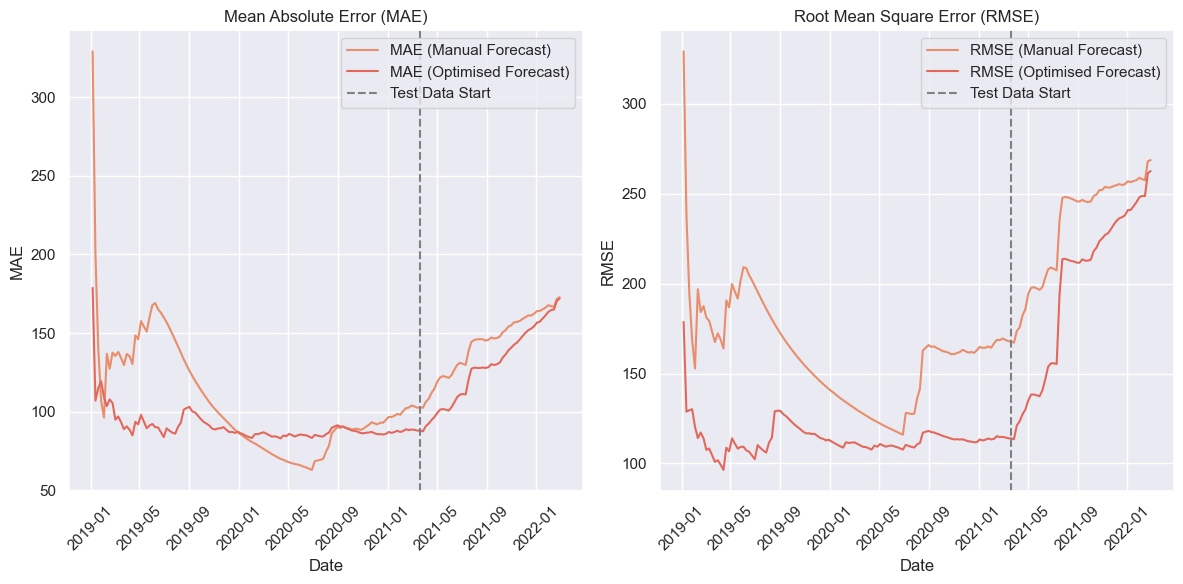

In [5]:
# Calculate and plot the mean absolute error (MAE) for both models over each step (show how the error increases/decreases by week)

mae1 = []
mae2 = []
rmse1 = []
rmse2 = []

# Combine training data predictions with test data predictions
full_forecast1 = np.concatenate([model1.fittedvalues, forecast1])
full_forecast2 = np.concatenate([model2.fittedvalues, forecast2])

for i in range(len(fire_weekly)):
    mae1.append(np.mean(np.abs(fire_weekly['FireCount'][:i+1] - full_forecast1[:i+1])))
    mae2.append(np.mean(np.abs(fire_weekly['FireCount'][:i+1] - full_forecast2[:i+1])))
    rmse1.append(np.sqrt(np.mean((fire_weekly['FireCount'][:i+1] - full_forecast1[:i+1])**2)))
    rmse2.append(np.sqrt(np.mean((fire_weekly['FireCount'][:i+1] - full_forecast2[:i+1])**2)))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(fire_weekly.index, mae1, label='MAE (Manual Forecast)', color=palette[0])
ax1.plot(fire_weekly.index, mae2, label='MAE (Optimised Forecast)', color=palette[1])
ax1.axvline(x=test_data.index[0], color='grey', linestyle='--', label='Test Data Start')  # Add vertical line
ax1.set_title('Mean Absolute Error (MAE)')
ax1.set_xlabel('Date')
ax1.tick_params(axis='x', rotation=45)
ax1.set_ylabel('MAE')
ax1.legend()

ax2.plot(fire_weekly.index, rmse1, label='RMSE (Manual Forecast)', color=palette[0])
ax2.plot(fire_weekly.index, rmse2, label='RMSE (Optimised Forecast)', color=palette[1])
ax2.axvline(x=test_data.index[0], color='grey', linestyle='--', label='Test Data Start')  # Add vertical line
ax2.set_title('Root Mean Square Error (RMSE)')
ax2.set_xlabel('Date')
ax2.tick_params(axis='x', rotation=45)
ax2.set_ylabel('RMSE')
ax2.legend()

plt.tight_layout()
plt.savefig(os.path.join(plot_path, 'Error_analysis.png'))
plt.show()

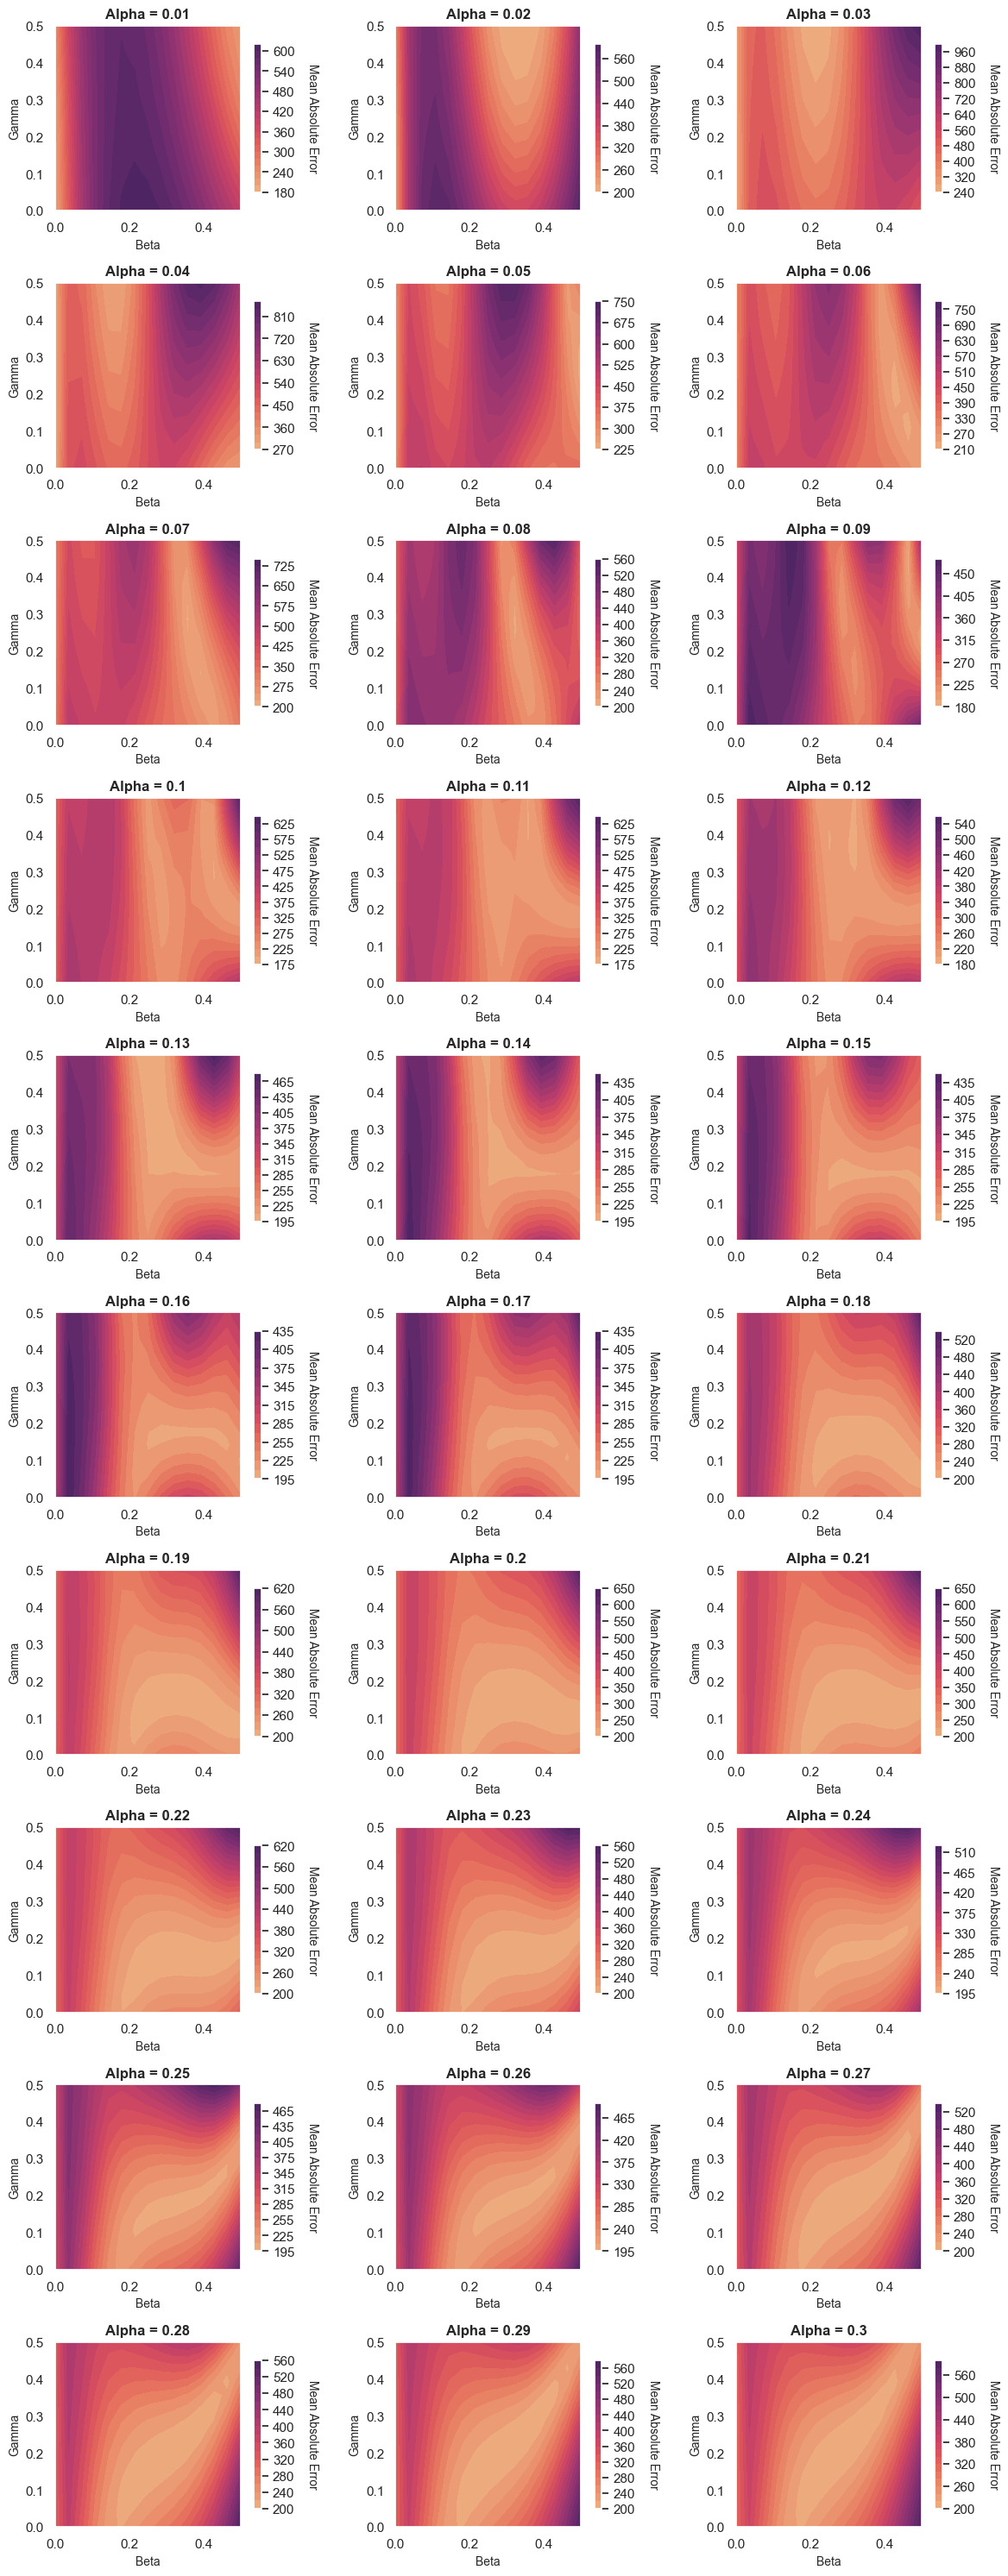

In [6]:
# Plot 2D contour map showing the error as beta and gamma vary

alpha_vals = np.linspace(0.01, 0.3, 30)  # Range of alpha values
beta_vals = np.linspace(0.0, 0.5, 15)
gamma_vals = np.linspace(0.0, 0.5, 15)

fig1, axes1 = plt.subplots(10, 3, figsize=(12, 30))
axes1 = axes1.flatten()

# fig2, axes2 = plt.subplots(10, 3, figsize=(12, 30))
# axes2 = axes2.flatten()

for i, alpha in enumerate(alpha_vals):
    # Create meshgrid for proper 2D contour plotting
    beta_grid, gamma_grid = np.meshgrid(beta_vals, gamma_vals)
    MAE_error_grid = np.zeros_like(beta_grid)
    RMSE_error_grid = np.zeros_like(beta_grid)
    
    # Fill the error grid
    for j, beta in enumerate(beta_vals):
        for k, gamma in enumerate(gamma_vals):
            try:
                model = ExponentialSmoothing(train_data['FireCount'],
                                             trend='add',
                                             seasonal='add',
                                             seasonal_periods=m).fit(
                    smoothing_level=alpha,
                    smoothing_trend=beta,
                    smoothing_seasonal=gamma,
                    optimized=False,
                    use_brute = True
                )
                forecast = model.forecast(steps=len(test_data))

                MAE_error = np.mean(np.abs(test_data['FireCount'] - forecast))
                MAE_error_grid[k, j] = MAE_error  # Note: k,j for proper orientation
                RMSE_error = np.sqrt(np.mean((test_data['FireCount'] - forecast) ** 2))
                RMSE_error_grid[k, j] = RMSE_error  # Note: k,j
                
            except Exception as e:
                print(f"Error with alpha={alpha}, beta={beta}, gamma={gamma}: {e}")
                MAE_error_grid[k, j] = np.nan

    # Create the contour plot of MAE
    ax1 = axes1[i]
    ax1.set_aspect('equal', adjustable='box')
    contour1 = ax1.contourf(beta_grid, gamma_grid, MAE_error_grid, 
                           levels=20, cmap=palette_cmap)
    
    ax1.set_xlabel('Beta', fontsize=10)
    ax1.set_ylabel('Gamma', fontsize=10)
    ax1.set_title(f'Alpha = {np.round(alpha, 2)}', fontsize=12, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    
    # Add colorbar for MAE subplot
    cbar1 = fig1.colorbar(contour1, ax=ax1, shrink=0.8)
    cbar1.set_label('Mean Absolute Error', rotation=270, labelpad=20, fontsize=10)

fig1.tight_layout(pad=1.0)  # Adjust layout to fit colorbar
plt.figure(fig1)
fig1.savefig(os.path.join(plot_path, '2D_contour_plots_MAE.png'), dpi=300, bbox_inches='tight')
plt.show()


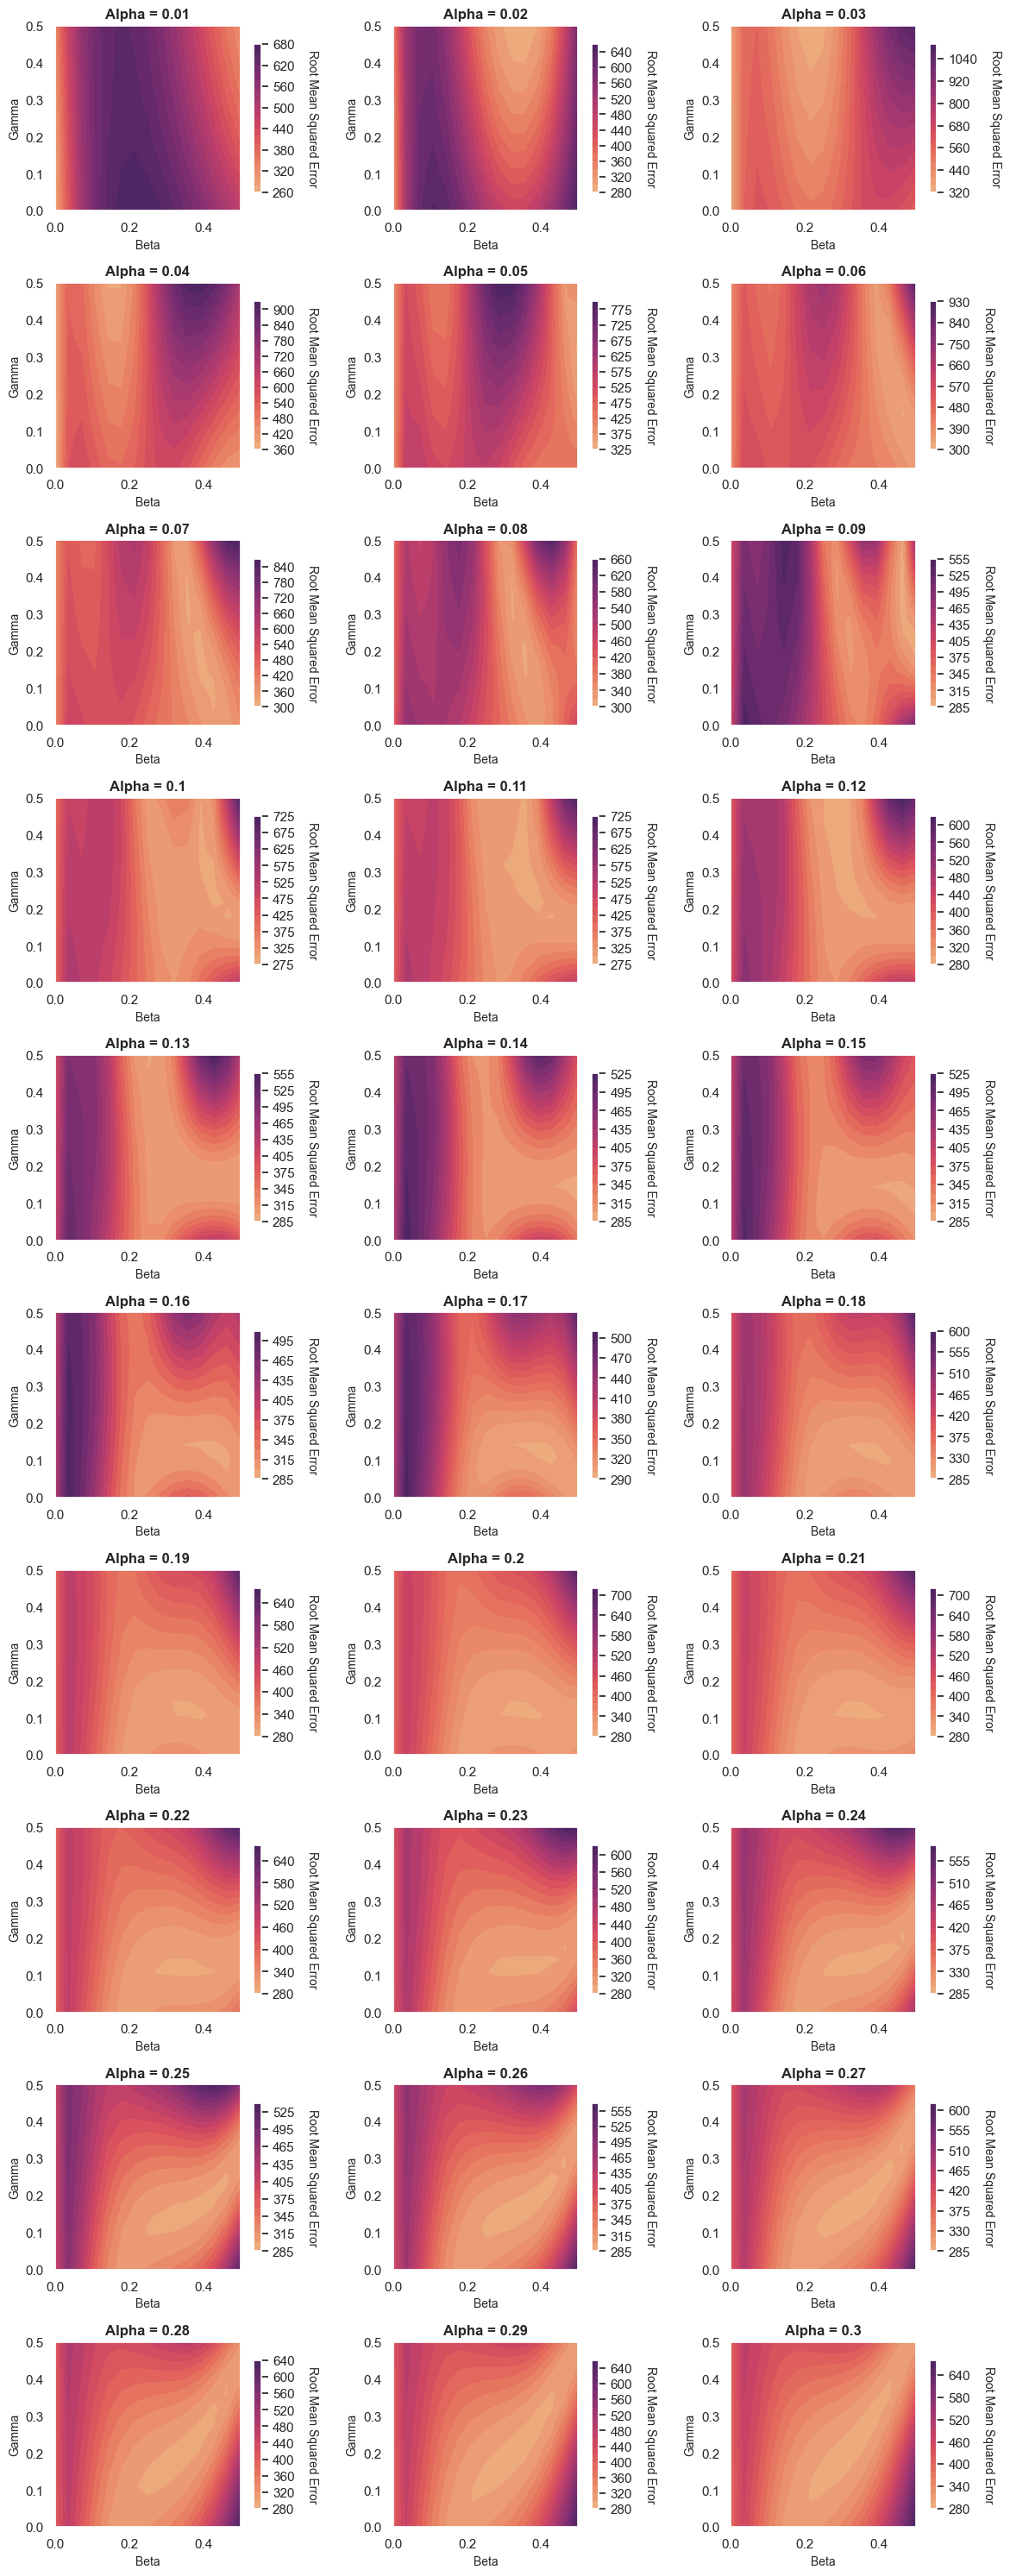

In [7]:
# Create a second contour plot to showing RMSE with varying alpha beta and gamma values

fig2, axes = plt.subplots(10, 3, figsize=(12, 30))
axes = axes.flatten()

for i, alpha in enumerate(alpha_vals):
    # Create meshgrid for proper 2D contour plotting
    beta_grid, gamma_grid = np.meshgrid(beta_vals, gamma_vals)
    MAE_error_grid = np.zeros_like(beta_grid)
    RMSE_error_grid = np.zeros_like(beta_grid)
    
    # Fill the error grid
    for j, beta in enumerate(beta_vals):
        for k, gamma in enumerate(gamma_vals):
            try:
                model = ExponentialSmoothing(train_data['FireCount'],
                                             trend='add',
                                             seasonal='add',
                                             seasonal_periods=m).fit(
                    smoothing_level=alpha,
                    smoothing_trend=beta,
                    smoothing_seasonal=gamma,
                    optimized=False,
                    use_brute=True
                )
                forecast = model.forecast(steps=len(test_data))

                MAE_error = np.mean(np.abs(test_data['FireCount'] - forecast))
                MAE_error_grid[k, j] = MAE_error  # Note: k,j for proper orientation
                RMSE_error = np.sqrt(np.mean((test_data['FireCount'] - forecast) ** 2))
                RMSE_error_grid[k, j] = RMSE_error  # Note: k,j
                
            except Exception as e:
                print(f"Error with alpha={alpha}, beta={beta}, gamma={gamma}: {e}")
                MAE_error_grid[k, j] = np.nan

    # Create the contour plot of RMSE
    ax2 = axes[i]
    ax2.set_aspect('equal', adjustable='box')
    contour2 = ax2.contourf(beta_grid, gamma_grid, RMSE_error_grid, 
                            levels=20, cmap=palette_cmap)
    ax2.set_xlabel('Beta', fontsize=10)
    ax2.set_ylabel('Gamma', fontsize=10)
    ax2.set_title(f'Alpha = {np.round(alpha, 2)}', fontsize=12, fontweight='bold')

    # Add colorbar for RMSE subplot
    cbar2 = fig2.colorbar(contour2, ax=ax2, shrink=0.8)
    cbar2.set_label('Root Mean Squared Error', rotation=270, labelpad=20, fontsize=10)

fig2.tight_layout(pad=1.0)  # Adjust layout to fit colorbar
plt.figure(fig2)
fig2.savefig(os.path.join(plot_path, '2D_contour_plots_RMSE.png'), dpi=300, bbox_inches='tight')
plt.show()


From the plots above, we can see that the built in optimiser for the triple exponential smoothing function did a poor job in forecasting the training or test data. Outisde of the training data, the MAE and RMSE values seem to increase drastically. By plotting the beta and gamma values for various alpha configurations, we can see that values of $\alpha = 0.11$, $\beta = 0.3$, $\gamma = 0.3$ have the potential to yield a better forecast when minimising MAE and RMSE.

C:\Users\conal\AppData\Local\Temp\ipykernel_18484\1327227890.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(0.02, 0.95, f'Optimised Model:\n Level: {model_opt.level[-1]:.2f}\nAlpha: {model_opt.params["smoothing_level"]:.2f}\nBeta: {model_opt.params["smoothing_trend"]:.2f}\nGamma: {model_opt.params["smoothing_seasonal"]:.2f}\nm: {m}', transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))
C:\Users\conal\AppData\Local\Temp\ipykernel_18484\1327227890.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(0.2, 0.95, f'New Model:\nLevel: {model_n

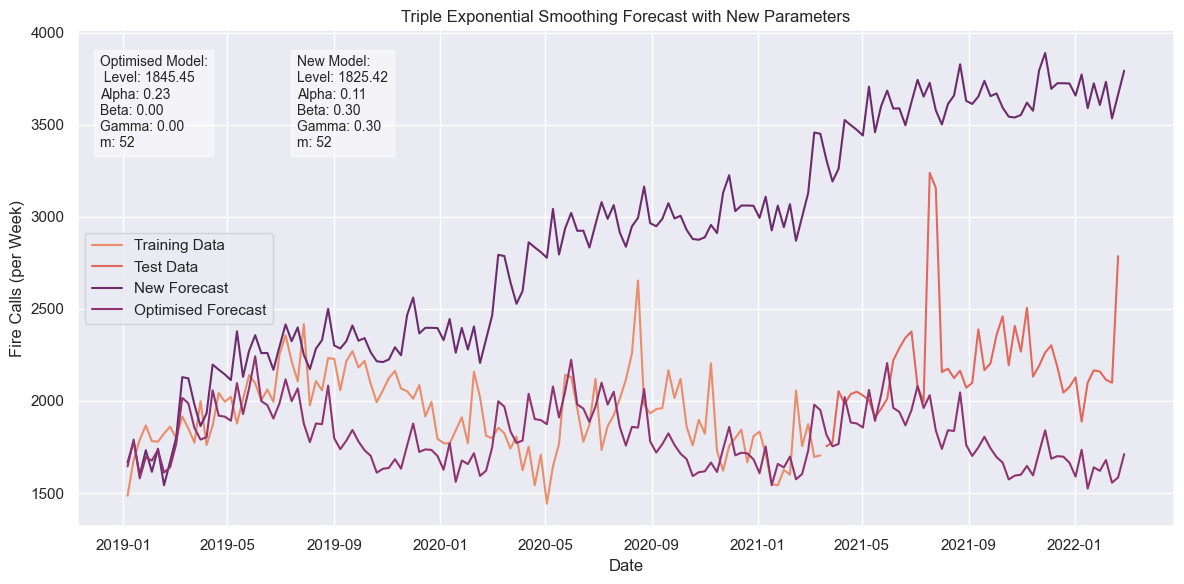

In [8]:
# Plot the forecast with the best alpha, beta, and gamma values
best_alpha = 0.11
best_beta = 0.3
best_gamma = 0.3

model_new = ExponentialSmoothing(train_data['FireCount'],
                                   trend='add',
                                   seasonal='add',
                                   seasonal_periods=m).fit(
    smoothing_level=best_alpha,
    smoothing_trend=best_beta,
    smoothing_seasonal=best_gamma,
    optimized=False
)

# Forecasting using the optimizer
model_opt = ExponentialSmoothing(train_data['FireCount'],
                                  trend='add',
                                  seasonal='add',
                                  seasonal_periods=m).fit(optimized=True)

forecast_new = model_new.forecast(steps=len(fire_weekly))
forecast_opt = model_opt.forecast(steps=len(fire_weekly))

plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['FireCount'], label='Training Data', color=palette[0])
plt.plot(test_data.index, test_data['FireCount'], label='Test Data', color=palette[1])
plt.plot(fire_weekly.index, forecast_new, label='New Forecast', color=palette[-1])
# Plot model with optimizer
plt.plot(fire_weekly.index, forecast_opt, label='Optimised Forecast', color=palette[-2])

plt.text(0.02, 0.95, f'Optimised Model:\n Level: {model_opt.level[-1]:.2f}\nAlpha: {model_opt.params["smoothing_level"]:.2f}\nBeta: {model_opt.params["smoothing_trend"]:.2f}\nGamma: {model_opt.params["smoothing_seasonal"]:.2f}\nm: {m}', transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

plt.text(0.2, 0.95, f'New Model:\nLevel: {model_new.level[-1]:.2f}\nAlpha: {best_alpha:.2f}\nBeta: {best_beta:.2f}\nGamma: {best_gamma:.2f}\nm: {m}', transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

plt.title('Triple Exponential Smoothing Forecast with New Parameters')
plt.xlabel('Date')
plt.ylabel('Fire Calls (per Week)')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(plot_path, 'Forecast_with_new_parameters.png'), dpi=300, bbox_inches='tight')
plt.show()


The plot above shows that the new $\alpha$, $\beta$ and $\gamma$ values found through the hyperparemeter study does not produce a stronger forecast as expected. This is likely because the optimisation model employed by the Exponential Smoothing tailors the initial search parameters(i.e. level) along with the $\alpha$, $\beta$ and $\gamma$ values. For further investigation, applying a dampened trend model might yield better results.

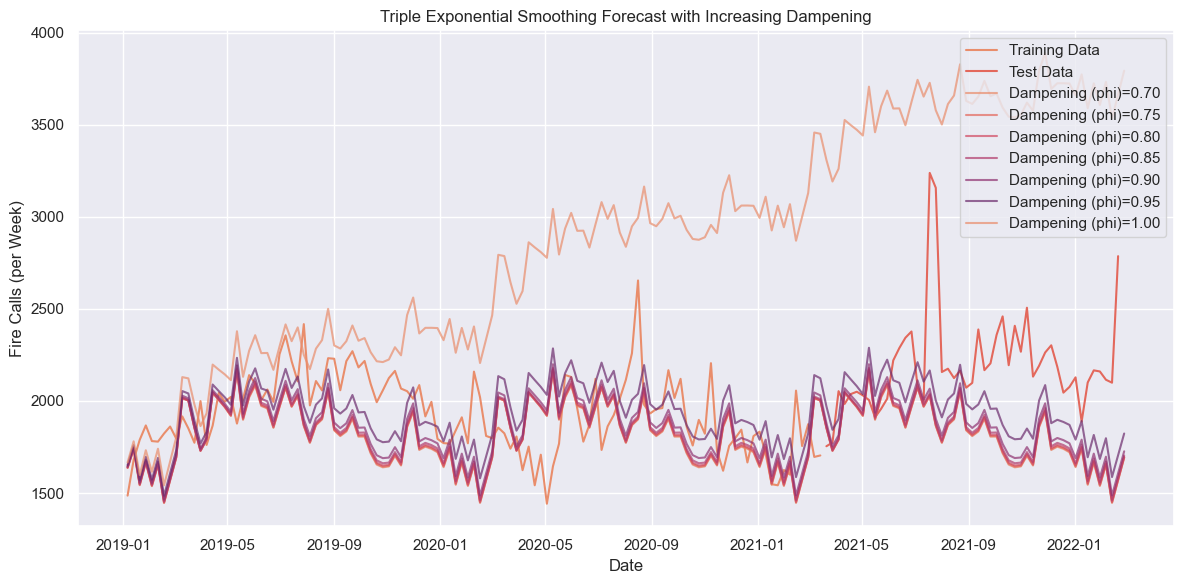

In [9]:
# Compare dampened trend model optimised with undampened trend model optimised

model_opt_undamp = ExponentialSmoothing(train_data['FireCount'],
                                  trend='add',
                                  seasonal='add',
                                  seasonal_periods=m).fit(optimized=True)

forecast_opt_undamp = model_opt_undamp.forecast(steps=len(fire_weekly))

phi_values = np.linspace(0.7, 1.0, 7)  # Range of phi (damping) values
forecasts = []

plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['FireCount'], label='Training Data', color=palette[0])
plt.plot(test_data.index, test_data['FireCount'], label='Test Data', color=palette[1])

for i, phi in enumerate(phi_values):
    model = ExponentialSmoothing(
        train_data['FireCount'],
        trend='add',
        seasonal='add',
        seasonal_periods=m,
        damped_trend=True
    ).fit(
        smoothing_level=best_alpha,
        smoothing_trend=best_beta,
        smoothing_seasonal=best_gamma,
        damping_trend=phi,
        optimized=False
    )
    forecast = model.forecast(steps=len(fire_weekly))
    plt.plot(fire_weekly.index, forecast, label=f'Dampening (phi)={phi:.2f}', alpha=0.7)

plt.title('Triple Exponential Smoothing Forecast with Increasing Dampening')
plt.xlabel('Date')
plt.ylabel('Fire Calls (per Week)')
plt.legend(loc = 'upper right')
plt.tight_layout()
plt.savefig(os.path.join(plot_path, 'Dampened_vs_Undampened_forecast.png'))
plt.show()


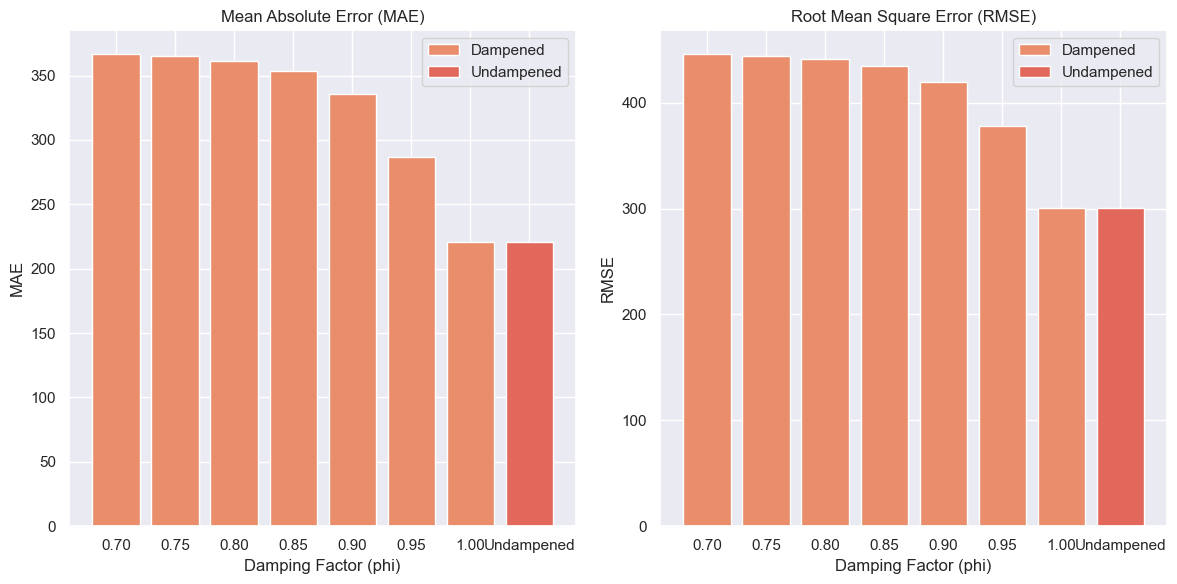

In [23]:

# Create 2 barcharts to show the MAE and RMSE of each of the damepened and undampened models

mae_dampened = []
mae_undampened = []
rmse_dampened = []
rmse_undampened = []

for i, phi in enumerate(phi_values):
    model = ExponentialSmoothing(
        train_data['FireCount'],
        trend='add',
        seasonal='add',
        seasonal_periods=m,
        damped_trend=True
    ).fit(
        smoothing_level=best_alpha,
        smoothing_trend=best_beta,
        smoothing_seasonal=best_gamma,
        damping_trend=phi,
        optimized=False
    )
    forecast = model.forecast(steps=len(test_data))
    
    mae_dampened.append(np.mean(np.abs(test_data['FireCount'] - forecast)))
    rmse_dampened.append(np.sqrt(np.mean((test_data['FireCount'] - forecast) ** 2)))

model_undampened = ExponentialSmoothing(
    train_data['FireCount'],
    trend='add',
    seasonal='add',
    seasonal_periods=m
).fit(
    smoothing_level=best_alpha,
    smoothing_trend=best_beta,
    smoothing_seasonal=best_gamma,
    optimized=False
)

forecast_undampened = model_undampened.forecast(steps=len(test_data))
mae_undampened.append(np.mean(np.abs(test_data['FireCount'] - forecast_undampened)))
rmse_undampened.append(np.sqrt(np.mean((test_data['FireCount'] - forecast_undampened) ** 2)))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.bar(range(len(phi_values)), mae_dampened, label='Dampened', color=palette[0])
ax1.bar(len(phi_values), mae_undampened[0], label='Undampened', color=palette[1])
ax1.set_xticks(range(len(phi_values) + 1))
ax1.set_xticklabels([f'{phi:.2f}' for phi in phi_values] + ['Undampened'])
ax1.set_title('Mean Absolute Error (MAE)')
ax1.set_xlabel('Damping Factor (phi)')
ax1.set_ylabel('MAE')
ax1.legend()

ax2.bar(range(len(phi_values)), rmse_dampened, label='Dampened', color=palette[0])
ax2.bar(len(phi_values), rmse_undampened[0], label='Undampened', color=palette[1])
ax2.set_xticks(range(len(phi_values) + 1))
ax2.set_xticklabels([f'{phi:.2f}' for phi in phi_values] + ['Undampened'])
ax2.set_title('Root Mean Square Error (RMSE)')
ax2.set_xlabel('Damping Factor (phi)')
ax2.set_ylabel('RMSE')
ax2.legend()

plt.tight_layout()
plt.savefig(os.path.join(plot_path, 'Dampened_vs_Undampened_error_analysis.png'), dpi=300, bbox_inches='tight')
plt.show()

The dampened forecast does not seem to outperform the undampened forecast. The next step is to apply multiplicative forecastig to measure the MAE and RMSE. In order ot do this, the data must be shifted to avoid negative multiplication.

C:\Users\conal\AppData\Local\Temp\ipykernel_18484\574652173.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(0.02, 0.95, f'Optimised (Seasonal) Multiplicative Model:\n Level: {mul_model.level[-1]:.2f}\nAlpha: {mul_model.params["smoothing_level"]:.2f}\nBeta: {mul_model.params["smoothing_trend"]:.2f}\nGamma: {mul_model.params["smoothing_seasonal"]:.2f}\nm: {m}', transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))
C:\Users\conal\AppData\Local\Temp\ipykernel_18484\574652173.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(0.4, 0.95, f'Opt

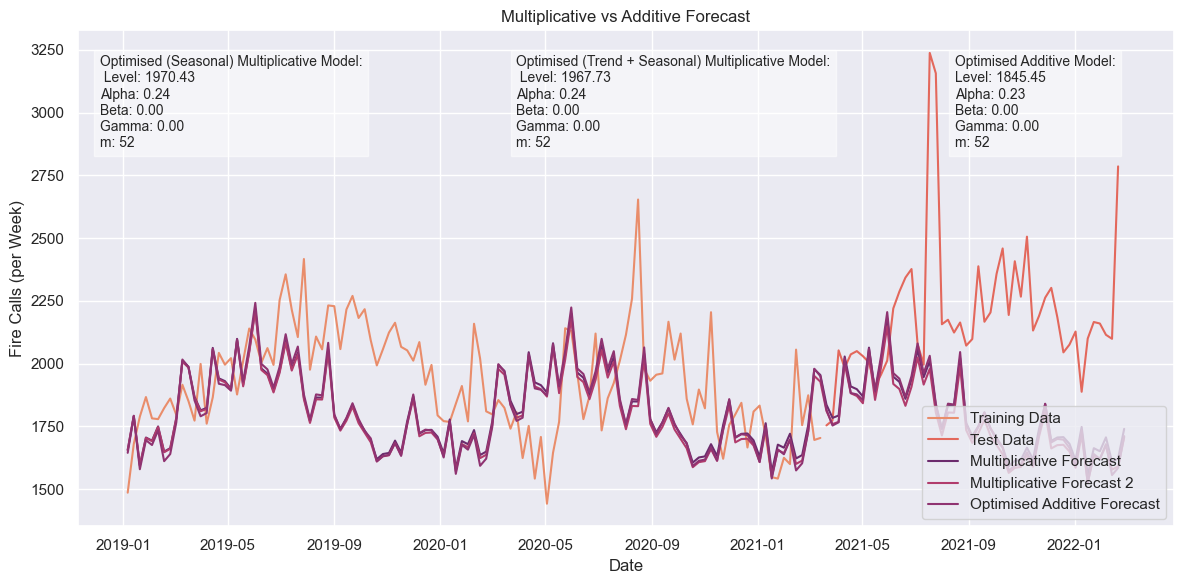

In [24]:
# Apply a multiplicative forecast and compare to the additive forecast for undampened

mul_model = ExponentialSmoothing(
    train_data['FireCount'],
    trend='additive',
    seasonal='mul',
    seasonal_periods=m
).fit(optimized=True)

mult_model2 = ExponentialSmoothing(
    train_data['FireCount'],
    trend='mul',
    seasonal='mul',
    seasonal_periods=m
).fit(optimized=True)

# Forecast for the trainging and test data
forecast_mul = mul_model.forecast(steps=len(fire_weekly))
forecast_mul2 = mult_model2.forecast(steps=len(fire_weekly))

plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['FireCount'], label='Training Data', color=palette[0])
plt.plot(test_data.index, test_data['FireCount'], label='Test Data', color=palette[1])
plt.plot(fire_weekly.index, forecast_mul, label='Multiplicative Forecast', color=palette[-1])
plt.plot(fire_weekly.index, forecast_mul2, label='Multiplicative Forecast 2', color=palette[-3])
plt.plot(fire_weekly.index, forecast_opt_undamp, label='Optimised Additive Forecast', color=palette[-2])

plt.text(0.02, 0.95, f'Optimised (Seasonal) Multiplicative Model:\n Level: {mul_model.level[-1]:.2f}\nAlpha: {mul_model.params["smoothing_level"]:.2f}\nBeta: {mul_model.params["smoothing_trend"]:.2f}\nGamma: {mul_model.params["smoothing_seasonal"]:.2f}\nm: {m}', transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

plt.text(0.4, 0.95, f'Optimised (Trend + Seasonal) Multiplicative Model:\n Level: {mult_model2.level[-1]:.2f}\nAlpha: {mult_model2.params["smoothing_level"]:.2f}\nBeta: {mult_model2.params["smoothing_trend"]:.2f}\nGamma: {mult_model2.params["smoothing_seasonal"]:.2f}\nm: {m}', transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

plt.text(0.8, 0.95, f'Optimised Additive Model:\nLevel: {model_opt_undamp.level[-1]:.2f}\nAlpha: {model_opt_undamp.params["smoothing_level"]:.2f}\nBeta: {model_opt_undamp.params["smoothing_trend"]:.2f}\nGamma: {model_opt_undamp.params["smoothing_seasonal"]:.2f}\nm: {m}', transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

plt.title('Multiplicative vs Additive Forecast')
plt.xlabel('Date')
plt.ylabel('Fire Calls (per Week)')
plt.legend(loc = 'lower right')
plt.tight_layout()
plt.savefig(os.path.join(plot_path, 'Multiplicative_vs_Additive_forecast.png'), dpi=300, bbox_inches='tight')
plt.show()


Both optimised models still show values of beta and gamma of 0, indicating a failure to converge on optimal hyperparameters. Instead, the level, trend and seasonality component will be extracted manually and plotted.

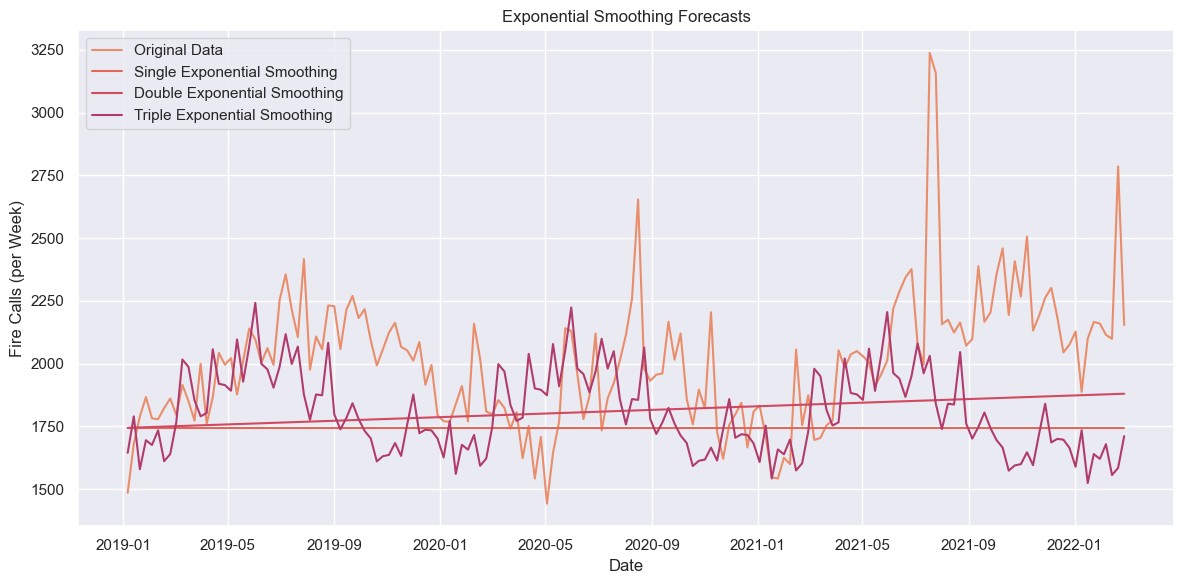

In [25]:
# Plot the original data, a single exponential smoothing forecast, a double exponential smoothing forecast, and a triple exponential smoothing forecast

model_single = ExponentialSmoothing(train_data['FireCount'], trend=None, seasonal=None).fit()
forecast_single = model_single.forecast(steps=len(fire_weekly))

model_double = ExponentialSmoothing(train_data['FireCount'], trend='add', seasonal=None).fit()
forecast_double = model_double.forecast(steps=len(fire_weekly))

model_triple = ExponentialSmoothing(train_data['FireCount'], trend='add', seasonal='add', seasonal_periods=52).fit()
forecast_triple = model_triple.forecast(steps=len(fire_weekly))

plt.figure(figsize=(12, 6))
plt.plot(fire_weekly.index, fire_weekly['FireCount'], label='Original Data', color=palette[0])
plt.plot(fire_weekly.index, forecast_single, label='Single Exponential Smoothing', color=palette[1])
plt.plot(fire_weekly.index, forecast_double, label='Double Exponential Smoothing', color=palette[2])
plt.plot(fire_weekly.index, forecast_triple, label='Triple Exponential Smoothing', color=palette[3])
plt.title('Exponential Smoothing Forecasts')
plt.xlabel('Date')
plt.ylabel('Fire Calls (per Week)')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(plot_path, 'Exponential_smoothing_forecasts.png'), dpi=300, bbox_inches='tight')
plt.show()


## S-ARIMA Modelling

Triple Exponential Smoothing is struggling to capture the complexity of the fire calls data, and so instead an ARIMA model might be applied, combining auto-regression (linear programming of previous values), and a moving average filter. This model is well-adept at handling time series data, balancing short term and long term memory.